In [36]:
import pandas as pd
import bert
import bertopic
import wos
import glob
import wosfile
import bertviz
import spacy
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
#import bertopic_base_chinese
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech



In [34]:
df = pd.read_csv(r'C:\Users\etien\OneDrive\Documents\Master 2\D2SN\Machine learning\Mémoire\Data\df_avec_topics_pays_villes(1).csv')
#text

In [35]:
text=df[ 'Résumé_translated']

In [39]:
# Initialisation du modèle SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Prétraitement des documents pour uniformiser les mots et supprimer les termes indésirables
def preprocess_text(texts, custom_stopwords):
    processed_texts = []
    for text in texts:
        for word in custom_stopwords:
            text = text.replace(word, "")
        processed_texts.append(text.lower())
    return processed_texts

# Liste de mots à exclure avec les stopwords
custom_stopwords = ["developpement", "article", "study", "household", "paper", 'data', "research"]

# Encodage des documents pour obtenir les embeddings
text = preprocess_text(text, custom_stopwords)
embeddings = embedding_model.encode(text, show_progress_bar=True)

# Configuration de UMAP pour la réduction de dimensionnalité
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.7, metric='cosine', random_state=42)

# Configuration de HDBSCAN pour la clusterisation
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Configuration du Vectorizer avec les stopwords et ngram_range ajustés
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=2)

# Initialisation des modèles de représentation de sujets
keybert_model = KeyBERTInspired()
pos_model = PartOfSpeech("en_core_web_sm")
mmr_model = MaximalMarginalRelevance(diversity=0.3)

client = openai.OpenAI(api_key="api_secret")
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

representation_model = {
    "KeyBERT": keybert_model,
    "OpenAI": openai_model,
    "MMR": mmr_model,
    "POS": pos_model
}

# Initialisation de BERTopic avec les modèles configurés
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    top_n_words=10,
    verbose=True
)

# Entraînement du modèle
topics, probs = topic_model.fit_transform(text, embeddings)

# Génération des étiquettes de sujets en utilisant le modèle OpenAI
chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "Outlier Topic"
topic_model.set_topic_labels(chatgpt_topic_labels)


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

2024-06-13 23:16:16,545 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-13 23:16:39,578 - BERTopic - Dimensionality - Completed ✓
2024-06-13 23:16:39,580 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-13 23:16:39,900 - BERTopic - Cluster - Completed ✓
2024-06-13 23:16:39,906 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 11/11 [00:07<00:00,  1.40it/s]
2024-06-13 23:17:03,804 - BERTopic - Representation - Completed ✓


In [33]:
import joblib
import numpy as np

# Chemin de sauvegarde
#model_save_path = r"C:\Users\etien\OneDrive\Documents\Master 2\D2SN\Machine learning\Mémoire\Data\Bert_Model"

# Enregistrer le modèle BERTopic
#joblib.dump(topic_model, f"{model_save_path}/bertopic_model.pkl")

# Sauvegarder les embeddings
#np.save(f"{model_save_path}/embeddings.npy", embeddings)

# Chemin de chargement
model_load_path = r"C:\Users\etien\OneDrive\Documents\Master 2\D2SN\Machine learning\Mémoire\Data\Bert_Model"

# Charger le modèle BERTopic
topic_model = joblib.load(f"{model_load_path}/bertopic_model.pkl")

# Charger les embeddings
embeddings = np.load(f"{model_load_path}/embeddings.npy", allow_pickle=True)

In [40]:


# Sauvegarde du modèle
#topic_model.save(r"C:\Users\etien\OneDrive\Documents\Master 2\D2SN\Machine learning\Mémoire\Data\Bert_Model", serialization="safetensors", save_ctfidf=True, save_embedding_model="sentence-transformers/all-MiniLM-L6-v2")
#Charger le modele
from bertopic import BERTopic

# Charger le modèle BERTopic sauvegardé
topic_model = BERTopic.load(r"C:\Users\etien\OneDrive\Documents\Master 2\D2SN\Machine learning\Mémoire\Data\Bert_Model", embedding_model="sentence-transformers/all-MiniLM-L6-v2")

## Résultats

In [41]:
# Toutes les representations pour un topic particulier
topic_model.get_topic(1, full=True)

{'Main': [['management', 0.04157664734702335],
  ['water', 0.036033578142484465],
  ['forest', 0.02950417665650912],
  ['waste', 0.02889171446419894],
  ['community', 0.028019014282382317],
  ['conservation', 0.026828339185545474],
  ['local', 0.018996575548952857],
  ['communities', 0.017604465448983333],
  ['resources', 0.01624311553573134],
  ['based', 0.01609248465867162]],
 'KeyBERT': [['waste management', 0.5873876810073853],
  ['sustainability', 0.43179696798324585],
  ['natural resource', 0.42392396926879883],
  ['solid waste', 0.4192824363708496],
  ['sustainable', 0.40470802783966064],
  ['recycling', 0.4028875231742859],
  ['livelihood', 0.3986928462982178],
  ['natural resources', 0.39710360765457153],
  ['waste', 0.3888402581214905],
  ['livelihoods', 0.3823551535606384]],
 'OpenAI': [['Community-Based Conservation Initiatives', 1]],
 'MMR': [['management', 0.04157664734702335],
  ['water', 0.036033578142484465],
  ['forest', 0.02950417665650912],
  ['waste', 0.02889171446

# **Les dix termes qui définissent chaque topic**

In [21]:
top1=pd.DataFrame(topic_model.get_topic(0))
top2=pd.DataFrame(topic_model.get_topic(1))
top3=pd.DataFrame(topic_model.get_topic(2))
top4=pd.DataFrame(topic_model.get_topic(3))
top5=pd.DataFrame(topic_model.get_topic(4))
top6= pd.DataFrame(topic_model.get_topic(5))
top7= pd.DataFrame(topic_model.get_topic(6))
top8= pd.DataFrame(topic_model.get_topic(7))
top9= pd.DataFrame(topic_model.get_topic(8))
top10= pd.DataFrame(topic_model.get_topic(9))


In [22]:
pd.concat([top1[0], top2[0], top3[0], top4[0], top5[0], top6[0], top7[0],top8[0], top9[0],top10[0]],axis=1)

0              0           0               0            0  \
0          food     management   countries         climate         land   
1       farmers          water      growth      adaptation        urban   
2  agricultural      community    economic          change      housing   
3         rural          waste      africa  climate change     planning   
4    households         forest     african   vulnerability       tenure   
5     household   conservation       trade         farmers        paper   
6         women          local     results      strategies  development   
7       poverty          study       study   environmental         city   
8         study    communities      effect           study     informal   
9        income  environmental  investment      households       rights   

             0            0              0                   0  \
0  development    education         mobile              health   
1        local       school            ict               covid   
2      article     children         phones                  19   
3   government        youth    information            covid 19   
4       social   employment       internet                care   
5        state       gender          study            pandemic   
6    political      primary  mobile phones  health expenditure   
7     research        child        digital         health care   
8    community  educational          phone         expenditure   
9       public    secondary            use               child   

                     0  
0            financial  
1               credit  
2                 bank  
3            inclusion  
4  financial inclusion  
5              banking  
6         microfinance  
7               access  
8                banks  
9                study

Distribution Sujet-Document

In [42]:
# `topic_distr` contient la distribution des topics dans chaque document
topic_distr, _ = topic_model.approximate_distribution(text, window=8, stride=4)

100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


In [43]:
# Visualisation de la distribution topic-document distribution pour un document
topic_model.visualize_distribution(topic_distr[100], custom_labels=True)

In [77]:
# Calcule des istributions de sujet au niveau des tokens
topic_distr, topic_token_distr = topic_model.approximate_distribution(text[1], calculate_tokens=True)

# Visualisation des distributions de token-level
dis_ = topic_model.visualize_approximate_distribution(text[1], topic_token_distr[0])
dis_

100%|██████████| 1/1 [00:00<00:00, 90.40it/s]


Réduction des Outliers

In [78]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(text, topics)

# Reduce outliers with pre-calculate embeddings instead
new_topics = topic_model.reduce_outliers(text, topics, strategy="embeddings", embeddings=embeddings)
# This line is to update the model with the latest topic assignment
topic_model.update_topics(text, topics=new_topics, vectorizer_model=vectorizer_model)

100%|██████████| 2/2 [00:07<00:00,  3.64s/it]
2024-06-13 23:42:56,179 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [82]:
# Visualize topics with custom labels
topic_model.visualize_topics(custom_labels=True)


In [84]:

topic_model.visualize_hierarchy(custom_labels=True)


In [87]:
#topic_model.get_representative_docs()
hierarchical_topics = topic_model.hierarchical_topics(text)
# Visualize hierarchy with custom labels
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)


#topic_model.get_topic_tree(hierarchical_topics)

100%|██████████| 9/9 [00:00<00:00, 74.24it/s]


Visualisation des documents

In [88]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [90]:
# Visualisation des documents dans un espace bidimensionnel
# NOTE: You can hide the hover with `hide_document_hover=True` which is especially helpful if you have a large dataset
# NOTE: You can also hide the annotations with `hide_annotations=True` which is helpful to see the larger structure
topic_model.visualize_documents(text, reduced_embeddings=reduced_embeddings, custom_labels=True)



WordCloud

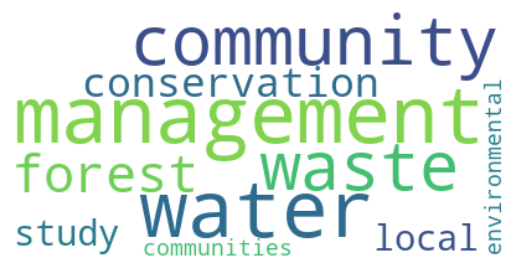

In [91]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=1)

In [1]:
#topic_model.visualize_barchart(top_n_topics=topics_count)
#topic_model.visualize_barchart(top_n_topics=5)

In [124]:
topic_model.visualize_barchart(n_words=4,top_n_topics=10)
#fig.write_html(r"C:\Users\etien\OneDrive\Documents\Master 2\D2SN\Machine learning\Mémoire\Notbook\Topics.html")

In [93]:
topic_model.visualize_heatmap()


In [95]:
topic_model.visualize_term_rank()


In [97]:
topic_model.visualize_term_rank(log_scale=True)


In [101]:
topics_over_time = topic_model.topics_over_time(df[ 'Résumé_translated'], df['Année de Publication'])
topic_model.visualize_topics_over_time(topics_over_time)
#fig.write_html(
# )




34it [00:06,  5.27it/s]


In [102]:
topics_over_time

Topic                                              Words  Frequency  \
0        1    wildlife, tourism, parks, protected areas, wild          1   
1        0  energy, fragmentation, zimbabwe, rural, agricu...          6   
2        1  community self, community, water, leone, sierr...          2   
3        5  local, government, reform, council, local gove...          9   
4        0  employment, peasant, self employment, scale, s...          6   
..     ...                                                ...        ...   
256      5   social, political, participation, cbos, informal          9   
257      6    education, children, school, employment, gender          9   
258      7       alcohol, ict, icts, generalised, consumption          1   
259      8  health, air pollution, health related, chws, p...          3   
260      9  financial, financial inclusion, inclusion, fin...          8   

     Timestamp                                    Name  
0       1990.0      1_management_water_community_waste  
1       1992.0       0_food_farmers_agricultural_rural  
2       1992.0      1_management_water_community_waste  
3       1992.0  5_development_local_article_government  
4       1993.0       0_food_farmers_agricultural_rural  
..         ...                                     ...  
256     2024.0  5_development_local_article_government  
257     2024.0       6_education_school_children_youth  
258     2024.0         7_mobile_ict_phones_information  
259     2024.0              8_health_covid_19_covid 19  
260     2024.0       9_financial_credit_bank_inclusion  

[261 rows x 5 columns]

In [103]:
# Ajouter une colonne 'Décennie'
topics_over_time['Décennie'] = (topics_over_time['Timestamp'] // 10) * 10

# Groupement des termes par décennie et par topic
terms_by_decade = topics_over_time.groupby(['Décennie', 'Topic'])['Words'].apply(lambda x: ' '.join(x)).reset_index()

# Convertir les termes en sets pour les comparaisons
terms_by_decade['Termes_Set'] = terms_by_decade['Words'].apply(lambda x: set(x.split(', ')))

# Dictionnaire pour stocker les résultats
terms_evolution = {}

# Comparer les termes entre les décennies
decades = sorted(terms_by_decade['Décennie'].unique())
topics = df['Topic'].unique()

for topic in topics:
    terms_evolution[str(topic)] = {}
    for i in range(1, len(decades)):
        previous_decade = terms_by_decade[(terms_by_decade['Décennie'] == decades[i-1]) & (terms_by_decade['Topic'] == topic)]
        current_decade = terms_by_decade[(terms_by_decade['Décennie'] == decades[i]) & (terms_by_decade['Topic'] == topic)]

        if not previous_decade.empty and not current_decade.empty:
            previous_terms = previous_decade['Termes_Set'].values[0]
            current_terms = current_decade['Termes_Set'].values[0]

            appeared_terms = current_terms - previous_terms
            disappeared_terms = previous_terms - current_terms
            constant_terms = previous_terms & current_terms

            terms_evolution[str(topic)][str(decades[i])] = {
                'Apparus': list(appeared_terms),
                'Disparus': list(disappeared_terms),
                'Constants': list(constant_terms)
            }

# Écrire les résultats dans un fichier JSON
import json
with open(r'C:\Users\etien\OneDrive\Documents\Master 2\D2SN\Machine learning\Mémoire\Data\terms_evolution.json', 'w', encoding='utf-8') as file:
    json.dump(terms_evolution, file, indent=2, ensure_ascii=False)


In [104]:
# Afficher les résultats
import json
print(json.dumps(terms_evolution, indent=2, ensure_ascii=False))

{
  "1.0": {
    "2000.0": {
      "Apparus": [
        "construction",
        "2001 wildlife",
        "service",
        "building",
        "solid waste",
        "waste management",
        "sadc sis",
        "community villagers",
        "tons",
        "sustainability",
        "procurement",
        "game waste",
        "harvesters",
        "management",
        "linkages",
        "environmental management",
        "appropriate",
        "solid",
        "waste management initiative",
        "city waste",
        "community based",
        "institutional",
        "forest",
        "scarcity regimes",
        "benefits community",
        "partnerships",
        "day",
        "conservation",
        "operators",
        "stakeholders",
        "resource degradation waste",
        "based",
        "recycling"
      ],
      "Disparus": [
        "people",
        "community",
        "fisheries",
        "commons",
        "leone",
        "tourism",
        "parks",
  

In [108]:
# Ajouter une colonne 'Décennie'
topics_over_time['Décennie'] = (topics_over_time['Timestamp'] // 10) * 10

# Groupement des termes par décennie et par topic
terms_by_decade = topics_over_time.groupby(['Décennie', 'Topic'])['Words'].apply(lambda x: ' '.join(x)).reset_index()

# Convertir les termes en sets pour les comparaisons
terms_by_decade['Termes_Set'] = terms_by_decade['Words'].apply(lambda x: set(x.split(', ')))

# Dictionnaire pour stocker les résultats
terms_evolution = {}
topic_focalization = {}

# Comparer les termes entre les décennies
decades = sorted(terms_by_decade['Décennie'].unique())
topics = df['Topic'].unique()

for topic in topics:
    terms_evolution[str(topic)] = {}
    for i in range(1, len(decades)):
        previous_decade = terms_by_decade[(terms_by_decade['Décennie'] == decades[i-1]) & (terms_by_decade['Topic'] == topic)]
        current_decade = terms_by_decade[(terms_by_decade['Décennie'] == decades[i]) & (terms_by_decade['Topic'] == topic)]

        if not previous_decade.empty and not current_decade.empty:
            previous_terms = previous_decade['Termes_Set'].values[0]
            current_terms = current_decade['Termes_Set'].values[0]

            appeared_terms = current_terms - previous_terms
            disappeared_terms = previous_terms - current_terms
            constant_terms = previous_terms & current_terms

            terms_evolution[str(topic)][str(decades[i])] = {
                'Apparus': list(appeared_terms),
                'Disparus': list(disappeared_terms),
                'Constants': list(constant_terms)
            }

# Calculer la focalisation sur les topics par décennie
for decade in decades:
    total_terms = terms_by_decade[terms_by_decade['Décennie'] == decade]['Words'].apply(lambda x: len(x.split(', '))).sum()
    topic_focalization[decade] = {}
    for topic in topics:
        topic_terms = terms_by_decade[(terms_by_decade['Décennie'] == decade) & (terms_by_decade['Topic'] == topic)]
        if not topic_terms.empty:
            topic_term_count = topic_terms['Words'].apply(lambda x: len(x.split(', '))).values[0]
            topic_focalization[decade][str(topic)] = topic_term_count / total_terms

# Afficher les résultats
results = {
    'terms_evolution': terms_evolution,
    'topic_focalization': topic_focalization
}
results_json = json.dumps(results, indent=2, ensure_ascii=False)
print(results_json)

{
  "terms_evolution": {
    "1.0": {
      "2000.0": {
        "Apparus": [
          "construction",
          "2001 wildlife",
          "service",
          "building",
          "solid waste",
          "waste management",
          "sadc sis",
          "community villagers",
          "tons",
          "sustainability",
          "procurement",
          "game waste",
          "harvesters",
          "management",
          "linkages",
          "environmental management",
          "appropriate",
          "solid",
          "waste management initiative",
          "city waste",
          "community based",
          "institutional",
          "forest",
          "scarcity regimes",
          "benefits community",
          "partnerships",
          "day",
          "conservation",
          "operators",
          "stakeholders",
          "resource degradation waste",
          "based",
          "recycling"
        ],
        "Disparus": [
          "people",
          "comm

In [40]:
#Frequance des topics par année et ainsique les termes les plus liés aux topics
topics_over_time.to_csv(r"C:\Users\etien\OneDrive\Documents\Master 2\D2SN\Machine learning\Mémoire\Data\dynamique_sujets.csv", index=False)

## **Ajoutons les topics dans le datafram final**

In [46]:
topic_predictions = topic_model.transform(df['Résumé_translated'])
# Assuming topic_predictions is the tuple containing topic indices and probabilities
topic_indices, probabilities = topic_predictions
df['topic'] = topic_indices
df['probability'] = probabilities

Batches:   0%|          | 0/90 [00:00<?, ?it/s]

In [90]:
topic_names = {
    0: "Agriculture",
    1: "Eau et Communautés",
    2: "Économie et Commerce",
    3: "Changement Climatique",
    4: "Urbanisme et Logement",
    5: "Gouvernance Locale",
    6: "Éducation et Emploi",
    7: "Technologie Mobile",
    8: "Santé et COVID",
    9: "Finance"
}
# Ajouter les noms des topics au DataFrame
df['titre_topic'] = df['topic'].map(topic_names)


In [91]:
#df.to_csv(r'C:\Users\etien\OneDrive\Documents\Master 2\D2SN\Machine learning\Mémoire\Data\df_avec_topics_pays_villes(1).csv', index=False)

In [88]:
df['titre_topic'].value_counts()

titre_topic
Agriculture              1145
Économie et Commerce      548
Changement Climatique     281
Finance                   216
Gouvernance Locale        160
Urbanisme et Logement     138
Eau et Communautés        133
Santé et COVID-19         132
Éducation et Emploi        67
Technologie Mobile         45
Name: count, dtype: int64

In [ ]:
df['topic_title'].value_counts(normalize=True)*100

# **La Géographie**

In [89]:
from geotext import GeoText

# Fonctions pour extraire les villes et les pays dans les adresses
def extract_cities(text):
    places = GeoText(text)
    return places.cities

def extract_countries(text):
    places = GeoText(text)
    return places.countries


df['Cities'] = df['ADRESSE_AUTEUR'].apply(lambda x: extract_cities(x if isinstance(x, str) else ""))
df['Countries'] = df['ADRESSE_AUTEUR'].apply(lambda x: extract_countries(x if isinstance(x, str) else ""))



In [90]:
#Les valeurs uniques de chaque pays
df['Unique_Countries'] = df['Countries'].apply(lambda x: list(set(x)))
#Valeurs uniques de chaque pays
df['Unique_Cities'] = df['Cities'].apply(lambda x: list(set(x)))

In [91]:
df_pays=df.explode("Unique_Countries")

In [92]:
print(f" il y'a {len(df_pays['Unique_Countries'].unique())} pays dans notre datafram")

 il y'a 132 pays dans notre datafram


In [93]:
print("La part de publications par pays")
df_pays['Unique_Countries'].value_counts(normalize=True)*100

La part de publications par pays


Unique_Countries
South Africa    27.149192
Ghana            7.967387
Kenya            6.594193
Nigeria          5.850379
Ethiopia         4.834788
                  ...    
Iran             0.014304
Romania          0.014304
Iceland          0.014304
Ivory Coast      0.014304
Gabon            0.014304
Name: proportion, Length: 131, dtype: float64

# **Le nombre d'articles sans collaboration internationale**

In [94]:
df_single_country = df[df['Unique_Cities'].apply(lambda x: len(x) == 1)]
print(f" {len(df_single_country)/len(df)*100} des articles sont sans collaboration internationale" )

 35.46038543897217 des articles sont sans collaboration internationale


In [ ]:
#df_Pop_resum_sans_na['Unique_Cities'].apply(len)

In [95]:
print(df["DOI"].isnull().sum(), "chapitres d'ouvrage")

1772 chapitres d'ouvrage


# **Visualisation des sujets**

In [96]:
topic_model.generate_topic_labels()

['0_food_households_poverty',
 '1_development_south_africa',
 '2_countries_growth_economic',
 '3_climate_change_climate change',
 '4_water_management_community',
 '5_ict_mobile_information']

In [97]:
topic_model.get_topic_freq()

Topic  Count
2      0   1632
0      1   1228
1      2    751
3      4    553
5      3    324
4      5    182

In [1]:
import pandas as pd
from pyvis.network import Network

In [107]:
df['Unique_Countries'] = df['Countries'].apply(lambda x: list(set(x)))
df_pays=df.explode ("Unique_Countries")

In [105]:
df_pays.columns

Index(['Type de Publication', 'Auteurs', 'Éditeurs',
       'Noms Complets des Auteurs', 'Titre', 'Nom de la Publication', 'Langue',
       'Type de Document', 'Mots-clés des Auteurs', 'Résumé',
       'Adresse des Auteurs',
       'Organisme de Financement et Numéro de Subvention', 'Références Citées',
       'Nombre de Références',
       'Nombre Total de Citations (toutes bases de données incluses)',
       'Date de Publication', 'Éditeur', 'Ville de l'Éditeur',
       'Année de Publication', 'Catégories Web of Science',
       'Domaines de Recherche', 'Identifiant Unique de l'Article', 'id',
       'Résumé_translated', 'Cities', 'Countries', 'topic', 'probability',
       'titre_topic', 'Unique_Countries'],
      dtype='object')

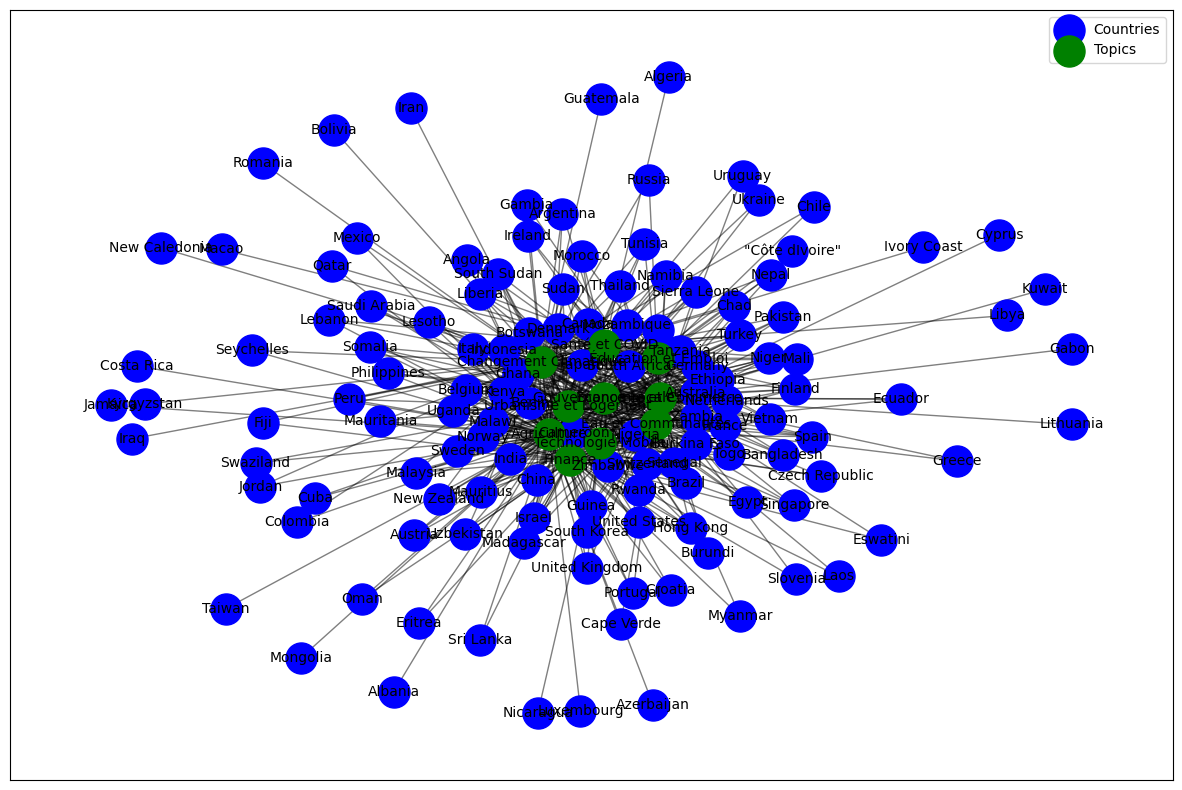

Le graphe a été créé et enregistré avec succès.


In [128]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que df soit votre DataFrame
# df = pd.read_csv('path_to_your_csv_file.csv')  # Remplacez par le chemin de votre fichier

# Fonction pour nettoyer le texte
def clean_text(text):
    if isinstance(text, list):
        text = ','.join(text)
    return text.strip('[]').replace("'", "").strip()

# Assurez-vous que la colonne 'Countries' est une liste de pays séparés par des virgules
df['Countries'] = df['Countries'].apply(clean_text)
df['titre_topic'] = df['titre_topic'].apply(clean_text)

# Création d'un graphe non dirigé
G = nx.Graph()

# Ajout des nœuds pour les topics et les pays avec les attributs nécessaires
for index, row in df.iterrows():
    countries = row['Countries'].split(',')  # Diviser la chaîne de pays en une liste
    for country in countries:
        country = country.strip()  # Supprimer les espaces autour des noms de pays
        if not G.has_node(country):
            G.add_node(country, type='country', name=country)

        if not G.has_node(row['titre_topic']):
            G.add_node(row['titre_topic'], type='topic', name=row['titre_topic'], topic_title=row['titre_topic'])

        # Ajouter l'arête entre le pays et le topic
        G.add_edge(
            country,
            row['titre_topic'],
            id=row['id'],
            date=row['Année de Publication'],
            categories_wos=row['Catégories Web of Science'],
            research_domain=row['Domaines de Recherche'],
            probability=row['probability'],
            topic_title=row['titre_topic']
        )

# Ajout d'attributs temporels pour les arêtes (ici, les dates de publication)
for u, v, d in G.edges(data=True):
    d['start'] = d['date']

# Visualisation du graphe (optionnelle)
plt.figure(figsize=(15, 10))  # Augmenter la taille de la figure
pos = nx.spring_layout(G, k=0.1)  # positions for all nodes

# Nodes
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G if G.nodes[n]['type'] == 'country'],
                       node_color='blue', node_size=500, label='Countries')
nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G if G.nodes[n]['type'] == 'topic'],
                       node_color='green', node_size=500, label='Topics')

# Edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.legend(scatterpoints=1)
plt.show()

# Enregistrer le graphe pour une utilisation ultérieure dans Gephi
nx.write_gexf(G, "C:/Users/etien/OneDrive/Documents/Master 2/D2SN/Machine learning/Mémoire/Data/countries_topics_network_collaboration.gexf", version='1.2draft')

print("Le graphe a été créé et enregistré avec succès.")


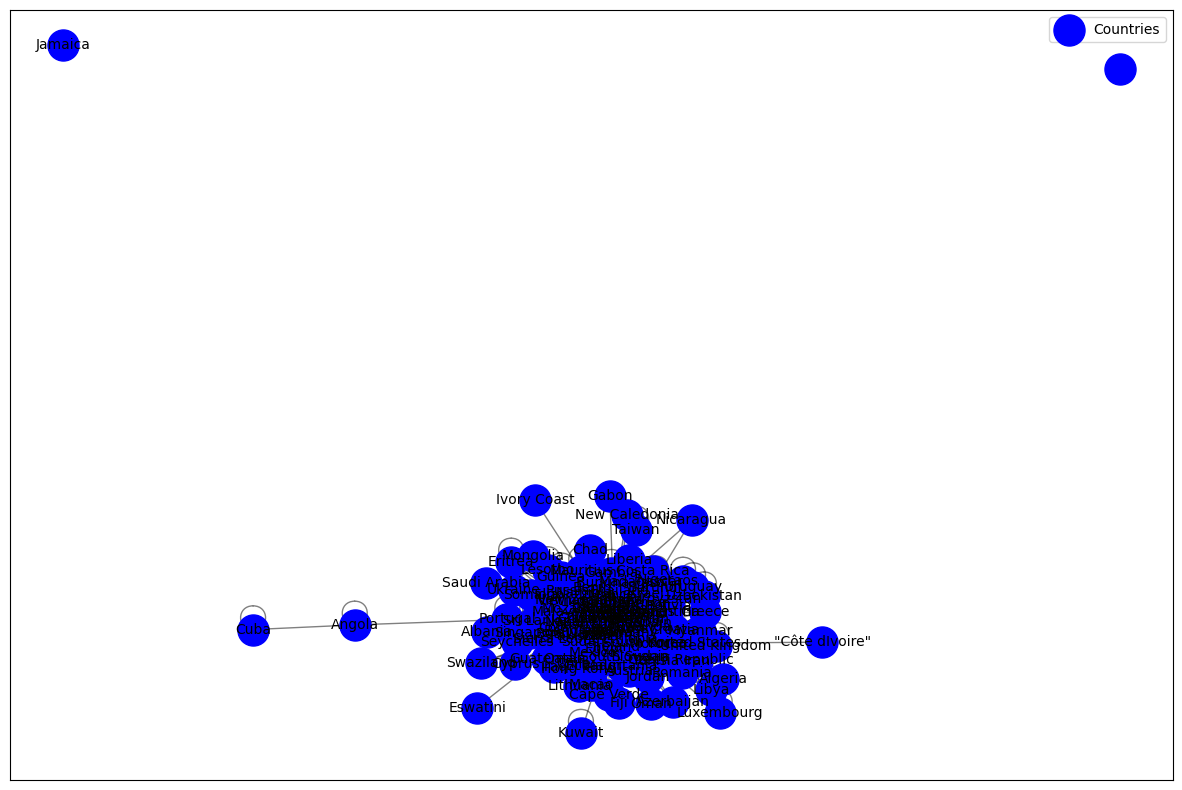

Le graphe a été créé et enregistré avec succès.


In [137]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que df soit votre DataFrame
# df = pd.read_csv('path_to_your_csv_file.csv')  # Remplacez par le chemin de votre fichier

# Fonction pour nettoyer le texte
def clean_text(text):
    if isinstance(text, list):
        text = ','.join(text)
    return text.strip('[]').replace("'", "").strip()

# Assurez-vous que la colonne 'Countries' est une liste de pays séparés par des virgules
df['Countries'] = df['Countries'].apply(clean_text)
df['titre_topic'] = df['titre_topic'].apply(clean_text)

# Création d'un graphe non dirigé
G = nx.Graph()

# Ajout des nœuds pour les pays et des arêtes basées sur les collaborations
for index, row in df.iterrows():
    countries = row['Countries'].split(',')  # Diviser la chaîne de pays en une liste
    cleaned_countries = [country.strip() for country in countries]  # Supprimer les espaces autour des noms de pays

    # Ajouter les nœuds pour chaque pays
    for country in cleaned_countries:
        if not G.has_node(country):
            G.add_node(country, type='country', name=country)

    # Ajouter des arêtes entre chaque paire de pays dans la collaboration
    for i in range(len(cleaned_countries)):
        for j in range(i + 1, len(cleaned_countries)):
            country1 = cleaned_countries[i]
            country2 = cleaned_countries[j]
            if not G.has_edge(country1, country2):
                G.add_edge(
                    country1, country2,
                    id=row['id'],
                    date=row['Année de Publication'],
                    categories_wos=row['Catégories Web of Science'],
                    research_domain=row['Domaines de Recherche'],
                    probability=row['probability'],
                    topic_title=row['titre_topic']
                )

# Ajout d'attributs temporels pour les arêtes (ici, les dates de publication)
for u, v, d in G.edges(data=True):
    d['start'] = d['date']

# Visualisation du graphe (optionnelle)
plt.figure(figsize=(15, 10))  # Augmenter la taille de la figure
pos = nx.spring_layout(G, k=0.1)  # positions for all nodes

# Nodes
nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=500, label='Countries')

# Edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.legend(scatterpoints=1)
plt.show()

# Enregistrer le graphe pour une utilisation ultérieure dans Gephi
nx.write_gexf(G, "C:/Users/etien/OneDrive/Documents/Master 2/D2SN/Machine learning/Mémoire/Data/countries_network_collaboration.gexf", version='1.2draft')

print("Le graphe a été créé et enregistré avec succès.")


In [142]:
from networkx.algorithms.community import greedy_modularity_communities

# Calcul des degrés (degré total)
degree_total = dict(G.degree())

# Calcul des degrés internes et externes
degree_internal = {node: sum(1 for neighbor in G.neighbors(node) if neighbor == node) for node in G.nodes()}
degree_external = {node: degree_total[node] - degree_internal[node] for node in G.nodes()}

# Calcul des centralités
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Détection des communautés
communities = list(greedy_modularity_communities(G))

# Affichage des 10 pays avec les plus grands degrés totaux
top_10_degrees = sorted(degree_total.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_internal = sorted(degree_internal.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_external = sorted(degree_external.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Convertir les communautés en un DataFrame pour une meilleure visualisation
communities_df = pd.DataFrame({'Country': list(G.nodes()), 'Community': [next(i for i, comm in enumerate(communities) if country in comm) for country in G.nodes()]})

# Affichage des résultats
print("Top 10 pays par degré total:")
for country, degree in top_10_degrees:
    print(f"{country}: {degree}")

print("\nTop 10 pays par degré interne:")
for country, degree in top_10_internal:
    print(f"{country}: {degree}")

print("\nTop 10 pays par degré externe:")
for country, degree in top_10_external:
    print(f"{country}: {degree}")

print("\nTop 10 pays par degré de centralité:")
for country, centrality in top_10_degree_centrality:
    print(f"{country}: {centrality}")

print("\nTop 10 pays par degré d'intermédiarité:")
for country, centrality in top_10_betweenness_centrality:
    print(f"{country}: {centrality}")

# Affichage des communautés dans un DataFrame
print("\nCommunautés des pays:")
communities_df


Top 10 pays par degré total:
Kenya: 79
Ghana: 70
Nigeria: 68
Ethiopia: 66
Germany: 63
France: 58
Netherlands: 57
South Africa: 54
Tanzania: 50
Zambia: 50

Top 10 pays par degré interne:
Cameroon: 1
Tanzania: 1
Benin: 1
Italy: 1
South Sudan: 1
Kenya: 1
Uganda: 1
Nigeria: 1
Malawi: 1
Rwanda: 1

Top 10 pays par degré externe:
Kenya: 78
Ghana: 69
Nigeria: 67
Ethiopia: 65
Germany: 62
France: 57
Netherlands: 56
South Africa: 53
Tanzania: 49
Zambia: 49

Top 10 pays par degré de centralité:
Kenya: 0.6220472440944882
Ghana: 0.5511811023622047
Nigeria: 0.5354330708661417
Ethiopia: 0.5196850393700787
Germany: 0.49606299212598426
France: 0.45669291338582674
Netherlands: 0.44881889763779526
South Africa: 0.4251968503937008
Tanzania: 0.39370078740157477
Zambia: 0.39370078740157477

Top 10 pays par degré d'intermédiarité:
Kenya: 0.13182637798021507
Nigeria: 0.0790275299681167
Ghana: 0.0765036569476384
Ethiopia: 0.07415307145595647
Germany: 0.06237022967584433
France: 0.061478982575397696
China: 0.036

Country  Community
0       Cameroon          0
1       Tanzania          0
2          Benin          0
3          Italy          0
4    South Sudan          2
..           ...        ...
123     Slovenia          0
124     Mongolia          1
125    Lithuania          1
126    Guatemala          4
127         Iraq          4

[128 rows x 2 columns]